In [5]:
# hydrological packages

import hydroeval as he
from hydrotools.nwm_client import utils # I had to pip install this


# basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# system packages
from progressbar import ProgressBar
from datetime import datetime, date
import pickle as pkl
import warnings
warnings.filterwarnings("ignore")
import platform
import time

# data analysi packages
from scipy import optimize
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#load access key
HOME = os.path.expanduser('~')
path_01 = f'{HOME}/NWM-ML/Savalan/'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [4]:


def Model_Evaluation_Plots(DF, predictions):

# Subplots.
    fig, ax = plt.subplots(1,1, figsize=(8, 7))
    fig.patch.set_facecolor('white')

    #set min/max for y-axis of the predictions/observations
    ymin = min(DF['flow_cfs'])*1.1
    ymax = max(DF['flow_cfs'])*1.1

    #add color options
    colors = ['blue', 'orange', 'red','green']


    # Add predictions to plot
    for pred in np.arange(0, len(predictions),1):
        ax.scatter(DF['flow_cfs'], DF[predictions[pred]],
                   c=colors[pred], alpha=0.35, label=predictions[pred])

     # Add some parameters.
    ax.set_title('Streamflow Predictions', fontsize=16)
    ax.set_xlabel('Observations (cfs)', fontsize=14)
    ax.set_ylabel('Predictions (cfs)', fontsize=14,)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(ymin, ymax)
    ax.legend(fontsize=14, loc='upper right')

    #Add a 1:1 prediction:observation plot
    ax.plot((0,ymax),(0,ymax), linestyle = '--', color  = 'red')

    plt.show()


#Define some key model performance metics: RMSE, PBias, MAE, MAPE
def RMSE(DF, predictions):
    R = []
    for pred in np.arange(0, len(predictions),1):
        rmse = mean_squared_error(DF['flow_cfs'], DF[predictions[pred]], squared=False)
        R.append(rmse)
        #print('RMSE for ', predictions[pred], ' is ', rmse, ' cfs')
    return R

def MAPE(DF, predictions):
    P =[]
    for pred in np.arange(0, len(predictions),1):
        mape = round(mean_absolute_percentage_error(DF['flow_cfs'], DF[predictions[pred]])*100, 2)
        P.append(mape)
        #print('Mean Absolute Percentage Error for ', predictions[pred], ' is ', mape, '%')
    return P

def PBias(DF, predictions):
    PB = []
    for pred in np.arange(0, len(predictions),1):
        pbias = he.evaluator(he.pbias,  DF[predictions[pred]], DF['flow_cfs'])
        pbias = round(pbias[0],2)
        PB.append(pbias)
        #print('Percentage Bias for ', predictions[pred], ' is ', pbias, '%')
    return PB    
  
def KGE(DF, predictions):
    KG = []
    for pred in np.arange(0, len(predictions),1):
        kge, r, alpha, beta = he.evaluator(he.kge,  DF[predictions[pred]], DF['flow_cfs'])
        kge = round(kge[0],2)
        KG.append(kge)
        #print('Kling-Glutz Efficiency for ', predictions[pred], ' is ', kge)
    return KG


In [5]:
raw_training_data = pd.read_csv(path_01 + '03.output/01.data_preparation/raw_training_data.csv')
raw_training_data.pop('Unnamed: 0')
raw_training_data['station_id'] = raw_training_data['station_id'].astype('str')
raw_training_data.head()

,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
0,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-28,78.55521,-0.891007,-0.453991,0.0,1.2,55.0,301
1,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-29,98.61146,-0.891007,-0.453991,0.0,1.2,55.0,302
2,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-30,97.60208,-0.891007,-0.453991,0.0,1.1,54.0,303
3,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-31,99.33125,-0.891007,-0.453991,0.0,1.2,54.0,304
4,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-11-01,95.76354,-0.998630,0.052336,0.0,1.2,54.0,305


In [6]:
Training_DF = raw_training_data.copy()

### Editing the features based on the feature importance should be in the next cell!!!!!!!!!!!!!!!

In [7]:
# Editing the features based on the feature importance should be done here!!!!!!!!!!!!!!!

Training_DF.drop(['Mean_Ann_Precip_in', 'Perc_Herbace', 'Perc_Forest',
                        'Mean_Basin_Elev_ft'], axis=1, inplace=True)



### Remove headwater stations!!!!!!!

In [8]:
headwater_stations = ['10011500', '10109000', '10113500', '10128500', '10131000', '10146400', '10150500', '10154200',
'10172700', '10172800', '10172952']
Training_DF = Training_DF[~raw_training_data['station_id'].isin(headwater_stations)]

In [9]:
Training_DF.datetime = pd.to_datetime(Training_DF.datetime)

Training_DF.head()


,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
3079,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-01,9.250000,-0.891007,-0.453991,0.0,0.0,37.0,275
3080,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-02,8.654167,-0.891007,-0.453991,0.0,0.0,36.0,276
3081,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-03,9.466667,-0.891007,-0.453991,0.0,0.0,36.0,277
3082,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-04,11.833333,-0.891007,-0.453991,0.0,0.0,36.0,278
3083,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-05,10.195833,-0.891007,-0.453991,0.0,0.0,36.0,279


In [10]:
x_train_temp = Training_DF[Training_DF.datetime.dt.year != 2020]
x_train_temp.pop('station_id')
x_train_temp.pop('datetime')
y_train_temp = x_train_temp['flow_cfs']
x_train_temp.pop('flow_cfs')
x_train_temp.head()

,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,s1,s2,storage,swe,NWM_flow,DOY
3079,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,37.0,275
3080,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,36.0,276
3081,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,36.0,277
3082,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,36.0,278
3083,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,36.0,279


In [11]:

y_train = y_train_temp.to_numpy()

x_train = x_train_temp.to_numpy()

scaler = MinMaxScaler()


x_train_scaled = scaler.fit_transform(x_train)

y_scaled_train = scaler.fit_transform(y_train.reshape(-1, 1))

y_scaled_train.shape

(128879, 1)

In [12]:
x_test_temp = Training_DF[Training_DF.datetime.dt.year == 2020]
x_test_temp.head()

,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
12393,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,2020-01-01,48.351044,-0.438371,0.898794,0.0,6.90,61.0,1
12394,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,2020-01-02,50.033333,-0.438371,0.898794,0.0,7.25,61.0,2
12395,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,2020-01-03,48.821877,-0.438371,0.898794,0.0,7.30,60.0,3
12396,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,2020-01-04,47.367710,-0.438371,0.898794,0.0,7.30,60.0,4
12397,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,2020-01-05,46.633335,-0.438371,0.898794,0.0,7.30,60.0,5


In [13]:
x_test_temp_1 = x_test_temp.copy()
station_index_list = x_test_temp_1['station_id']
x_test_temp_1.pop('station_id')
x_test_temp_1.pop('datetime')
y_test_temp_1 = x_test_temp_1['flow_cfs']
x_test_temp_1.pop('flow_cfs')
x_test_1_np = x_test_temp_1.reset_index(drop=True).to_numpy()
y_test_1_np = y_test_temp_1.reset_index(drop=True).to_numpy()
x_test_1_scaled = scaler.fit_transform(x_test_1_np)
y_scaled_test_1 = scaler.fit_transform(y_test_1_np.reshape(-1, 1))

In [14]:
# %% MLP

n_targets = 1

tries = 10


cri_temp_nse = np.zeros([3, n_targets, tries])

cri_temp_rmse = np.zeros([3, n_targets, tries])

cri_temp_r2 = np.zeros([3, n_targets, tries])

cri_temp_kge = np.zeros([3, n_targets, tries])

cri_temp_lognse = np.zeros([3, n_targets, tries])


#remove first column
#Training_DF.pop('Unnamed: 0')

#Split the data into features and target
#y = Training_DF['flow_cfs'].to_numpy()

#remove target from features
#Training_DF.pop('flow_cfs')

#x = Training_DF.to_numpy()

'''The DataFrame looks good, now lets scale the data.
XGBoost does not require this but others do and it is a good housekeeping step.
'''



# split data into train and test sets
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

#x_scaled = scaler.fit_transform(x)

#y_scaled = scaler.fit_transform(y.reshape(-1, 1))

#x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(x_scaled, y_scaled, test_size=0.33, random_state=1)

print('finish')


finish


In [15]:
# Reshape Input for MLP Model
x_train_scaled_test = torch.Tensor(x_train_scaled)
y_train_scaled_test = torch.Tensor(y_scaled_train)




In [16]:
x_test_1_scaled.shape

(5473, 12)

In [17]:
y_train_scaled_test.shape

torch.Size([128879, 1])

In [18]:
x_train_scaled_test = x_train_scaled_test.to(device)
y_train_scaled_test = y_train_scaled_test.to(device)

In [19]:
start_time = time.time()
import datetime

# Assuming you have your data loaded into NumPy arrays as x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, x_scaled, y_scaled



# Hyperparameters
epochs = 6
batch_size = 100
learning_rate = 0.001
decay = 1e-2
validation_split = 0.2
neurons = 150
LD1=128
LD2=128
LD3=64
LD4=64
LD5=32
LD6=16
LD7=5

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(x_train_scaled_test, y_train_scaled_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False )

# Build the model
model = nn.Sequential(
    nn.Linear(12, LD1),
    nn.ReLU(),
    nn.Linear(LD1, LD2),
    nn.ReLU(),
    nn.Linear(LD2, LD3),
    nn.ReLU(),
    nn.Linear(LD3, LD4),
    nn.ReLU(),
    nn.Linear(LD4, LD5),
    nn.ReLU(),
    nn.Linear(LD5, LD6),
    nn.ReLU(),
    nn.Linear(LD6, 1)
).to(device)


# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop

for epoch in range(epochs):
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

print('finish')
print("Run Time:" + " %s seconds " % (time.time() - start_time))

#save model
model_path = f"{HOME}/NWM-ML/Model/MLP"
if os.path.exists(model_path) == False:
    os.mkdir(model_path)
torch.save(model.state_dict(), f"{model_path}/mlp_model.pkl")

Epoch 1/6, Loss: 0.0012313361469724654
Epoch 2/6, Loss: 0.0010941713546729836
Epoch 3/6, Loss: 0.0009802346659183692
Epoch 4/6, Loss: 0.0010167827427213295
Epoch 5/6, Loss: 0.0008438039603353162
Epoch 6/6, Loss: 0.0009246839763827413
finish
Run Time: 59.30599808692932 seconds 


In [21]:
dates = pd.date_range(pd.to_datetime("2020-01-01"), periods=len(nwm_test)).strftime("%Y-%m-%d").tolist()
#for date in dates:
 #   print(date.strftime("%Y-%m-%d"))
dates

NameError: name 'nwm_test' is not defined

In [28]:
# %%
# Build and load the model
device = torch.device('cpu') # for some reason had to change to cpu
models = nn.Sequential(
    nn.Linear(12, LD1),
    nn.ReLU(),
    nn.Linear(LD1, LD2),
    nn.ReLU(),
    nn.Linear(LD2, LD3),
    nn.ReLU(),
    nn.Linear(LD3, LD4),
    nn.ReLU(),
    nn.Linear(LD4, LD5),
    nn.ReLU(),
    nn.Linear(LD5, LD6),
    nn.ReLU(),
    nn.Linear(LD6, 1)
).to(device)

models.load_state_dict(torch.load(f"{model_path}/mlp_model.pkl"))

#put the model scores into a dataframe for comparison
#put the model scores into a dataframe for comparison
mod = 'MLP'
#Evaluation columns for prediction time series
cols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{mod}_rmse", 'NWM_pbias', f"{mod}_pbias", 
        'NWM_kge', f"{mod}__kge", 'NWM_mape',  f"{mod}_mape"]

#Evaluation columns for accumulated supply time series
supcols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{mod}_rmse", 'NWM_pbias', f"{mod}_pbias", 
        'NWM_kge', f"{mod}__kge", 'NWM_mape',  f"{mod}_mape", 'Obs_vol', 'NWM_vol', f"{mod}_vol",
        'NWM_vol_err', f"{mod}_vol_err", 'NWM_vol_Perc_diff', f"{mod}_vol_Perc_diff"]


EvalDF = pd.DataFrame(columns = cols)
SupplyEvalDF = pd.DataFrame(columns = supcols)

#get annual supply diffs
cfsday_AFday = 1.983

SitesDict = {}

for station_number in station_index_list.drop_duplicates():

    #print(station_number)
    index = station_index_list == station_number
    

    X_test = x_test_temp_1[index]

    X_test_scaled = torch.Tensor(x_test_1_scaled[index])
    y_test = y_test_temp_1[index]
    # Evaluation
    models.eval()
    with torch.no_grad():

        yhat_test= models(X_test_scaled)


    # Invert scaling for actual


    inv_yhat_test = scaler.inverse_transform(yhat_test.numpy())
    inv_yhat_test[inv_yhat_test<0] = 0

    #print('finish')
    # %%

    #nwm_mlp = np.concatenate((inv_yhat_train, inv_yhat_test), axis=0)

    nwm_test = pd.DataFrame(inv_yhat_test, columns=['MLP_flow'])

    Dfs = [nwm_test.reset_index(drop=True), x_test_temp_1[index].reset_index(drop=True), y_test.reset_index(drop=True)]

    #save predictions, need to convert to NHDPlus reach - Need to add Datetime column and relable flow predictions
    #make daterange
    dates = pd.date_range(pd.to_datetime("2020-01-01"), periods=len(nwm_test)).strftime("%Y-%m-%d").tolist()
    nwm_test['Datetime'] = dates
    #put columns in correct order
    cols = ['Datetime', 'MLP_flow']
    nwm_test = nwm_test[cols]
    
    #get reach id for model eval
    nhdreach = utils.crosswalk(usgs_site_codes=station_number)
    nhdreach = nhdreach['nwm_feature_id'].iloc[0]
    
    #save predictions
    mod = 'MLP'
    save_path = f"{HOME}/NWM-ML/Predictions/Hindcast/{mod}"
    if os.path.exists(save_path) == False:
        os.mkdir(save_path)
    nwm_test.to_csv(f"{save_path}/{mod}_{nhdreach}.csv")
    
      # merge
    Eval_DF_mine = pd.concat(Dfs, axis=1)
    prediction_columns = [ 'NWM_flow', 'MLP_flow']

    #plot the predictions
   # Model_Evaluation_Plots(Eval_DF_mine, prediction_columns)

    #Get RMSE from the model
    rmse = RMSE(Eval_DF_mine, prediction_columns)

    #Get Mean Absolute Percentage Error from the model
    mape = MAPE(Eval_DF_mine, prediction_columns)

    #Get Percent Bias from the model
    pbias = PBias(Eval_DF_mine, prediction_columns)

    #Get Kling-Gutz Efficiency from the model
    kge = KGE(Eval_DF_mine, prediction_columns)
    
      #Get Volumetric values
    Eval_DF_mine['Datetime'] = pd.to_datetime(dates)
    Eval_DF_mine.set_index('Datetime', inplace = True, drop =True)
    flowcols = [f"{mod}_flow", 'flow_cfs', 'NWM_flow']
    SupplyEval = Eval_DF_mine[flowcols].copy()
    SupplyEval = SupplyEval*cfsday_AFday
    #set up cumulative monthly values
    SupplyEval['Year'] = SupplyEval.index.year

    for site in flowcols:
        SupplyEval[site] = SupplyEval.groupby(['Year'])[site].cumsum()  

    EOY_mod_vol_af = SupplyEval[f"{mod}_flow"].iloc[-1]
    EOY_obs_vol_af = SupplyEval["flow_cfs"].iloc[-1]
    EOY_nwm_vol_af = SupplyEval[f"NWM_flow"].iloc[-1]
    NWM_vol_diff_af = EOY_nwm_vol_af - EOY_obs_vol_af
    Mod_vol_diff_af = EOY_mod_vol_af - EOY_obs_vol_af
    NWM_Perc_diff = (NWM_vol_diff_af/EOY_obs_vol_af)*100
    Mod_Perc_diff = (Mod_vol_diff_af/EOY_obs_vol_af)*100
    
     #Get Performance Metrics from the model
    Srmse = RMSE(SupplyEval, prediction_columns)
    Smape = MAPE(SupplyEval, prediction_columns)
    Spbias = PBias(SupplyEval, prediction_columns)
    Skge = KGE(SupplyEval, prediction_columns)
    
    
    #save model performance
    sitestats = [station_number, nhdreach, rmse[0], rmse[1],  pbias[0], pbias[1], kge[0], kge[1], mape[0],mape[1]]
    EvalDF.loc[len(EvalDF)] = sitestats
    
    Supplystats = [station_number, nhdreach, Srmse[0], Srmse[1],  Spbias[0], Spbias[1], Skge[0], Skge[1], Smape[0],  
                 Smape[1],EOY_obs_vol_af, EOY_nwm_vol_af,EOY_mod_vol_af,NWM_vol_diff_af,Mod_vol_diff_af, NWM_Perc_diff, Mod_Perc_diff ]
    SupplyEvalDF.loc[len(SupplyEvalDF)] = Supplystats
    
    
    
    
    #put prediction DF into dictionary
    Eval_DF_mine.sort_values(by=['DOY'], inplace=True)
    Eval_DF_mine['Datetime'] = pd.to_datetime(dates)
    Eval_DF_mine.set_index('Datetime', inplace = True)
    SitesDict[nhdreach] = Eval_DF_mine
    
#save model results
EvalDF.to_csv(f"./Predictions/Hindcast/{mod}/{mod}_Performance.csv")   
SupplyEvalDF.to_csv(f"./Predictions/Hindcast/{mod}/{mod}_Supply_Performance.csv")


print("Model Performance for Daily cfs")
display(EvalDF)   
print("Model Performance for Daily Accumulated Supply (Acre-Feet)")
display(SupplyEvalDF )

Model Performance for Daily cfs


,USGSid,NHDPlusid,NWM_rmse,MLP_rmse,NWM_pbias,MLP_pbias,NWM_kge,MLP__kge,NWM_mape,MLP_mape
0,10105900,666170,52.763309,54.983302,-36.75,-45.40,0.37,0.28,148.21,138.37
1,10126000,4605050,2004.216242,885.827891,-75.45,31.81,-0.71,0.22,368.22,73.43
2,10129900,10093082,58.555935,8.200299,-400.73,100.00,-10.60,NaN,392.79,100.00
3,10133650,10276856,54.142788,21.592195,-212.13,97.49,-2.13,-0.49,392.74,98.50
4,10133800,10276836,80.483443,41.658044,-164.71,100.00,-1.29,NaN,334.03,100.00
5,10133980,10276712,127.285708,44.155076,-234.33,84.10,-1.95,-0.13,431.71,88.12
6,10134500,10277268,141.565304,51.157425,-160.24,44.07,-1.01,0.10,393.93,70.28
7,10136500,10274616,669.746563,178.385983,-183.78,28.68,-1.33,0.41,285.84,61.80
8,10137500,10274270,66.070097,67.043596,28.12,13.91,0.33,0.24,29.53,46.20
9,10140100,10275828,178.156894,55.213197,-324.51,27.14,-2.32,-0.16,728.02,102.33


Model Performance for Daily Accumulated Supply (Acre-Feet)


,USGSid,NHDPlusid,NWM_rmse,MLP_rmse,NWM_pbias,MLP_pbias,NWM_kge,MLP__kge,NWM_mape,MLP_mape,Obs_vol,NWM_vol,MLP_vol,NWM_vol_err,MLP_vol_err,NWM_vol_Perc_diff,MLP_vol_Perc_diff
0,10105900,666170,5.409461e+03,8940.386660,-10.68,-33.18,0.75,0.55,16.93,44.80,37232.679662,50915.508,54134.464844,1.368283e+04,16901.785182,36.749513,45.395028
1,10126000,4605050,2.330694e+05,182886.474980,-17.18,39.76,0.15,0.52,38.70,43.40,655183.188796,1149487.593,446773.875000,4.943044e+05,-208409.313796,75.445221,-31.809319
2,10129900,10093082,1.050826e+04,2586.292674,-353.28,100.00,-5.51,NaN,256.94,100.00,3759.072756,18822.636,0.000000,1.506356e+04,-3759.072756,400.725504,-100.000000
3,10133650,10276856,1.081965e+04,6381.873380,-141.82,97.46,-1.51,-0.37,126.64,98.21,9663.116575,30161.430,242.938690,2.049831e+04,-9420.177884,212.129423,-97.485918
4,10133800,10276836,1.519312e+04,12423.292772,-102.64,100.00,-0.86,NaN,94.75,100.00,18057.498883,47800.215,0.000000,2.974272e+04,-18057.498883,164.711161,-100.000000
5,10133980,10276712,2.856723e+04,13511.926654,-158.35,85.98,-1.70,-0.18,147.36,90.43,23337.537876,78025.101,3710.357910,5.468756e+04,-19627.179966,234.333045,-84.101331
6,10134500,10277268,3.633052e+04,6124.788413,-223.35,29.37,-1.81,0.54,416.72,34.55,37262.276126,96970.683,20839.580078,5.970841e+04,-16422.696047,160.238217,-44.073250
7,10136500,10274616,1.874526e+05,19778.844028,-204.51,12.84,-1.74,0.71,334.93,39.68,172949.053299,490788.534,123354.585938,3.178395e+05,-49594.467361,183.776363,-28.675767
8,10137500,10274270,1.222244e+04,6544.246317,35.60,14.28,0.51,0.73,32.11,37.58,54744.014371,39350.652,47128.273438,-1.539336e+04,-7615.740933,-28.118804,-13.911550
9,10140100,10275828,5.521512e+04,4302.596669,-495.28,-17.44,-4.80,0.74,884.86,68.14,28156.377964,119525.325,20513.417969,9.136895e+04,-7642.959995,324.505329,-27.144685


In [42]:
#save model results
EvalDF.to_csv(f"./Predictions/Hindcast/{mod}/{mod}_Performance.csv")

for site in SitesDict.keys():
    SitesDict[site].rename(columns = {'flow_cfs':'Obs_flow'}, inplace =  True)



In [56]:
import pickle as pkl
save_path = f"{HOME}/NWM-ML/Predictions/Hindcast/{mod}"
with open(f'{save_path}/Pred_dict.pkl', 'wb') as handle:
    pkl.dump(SitesDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
mod = 'MLP'
save_path = f"{HOME}/NWM-ML/Predictions/Hindcast/{mod}"
with open(f'{save_path}/Pred_dict.pkl', 'rb') as handle:
    SitesDict = pkl.load(handle)

In [33]:
import importlib
importlib.reload(FigureGenerator)

<module 'FigureGenerator' from '/home/jovyan/NWM-ML/FigureGenerator.py'>

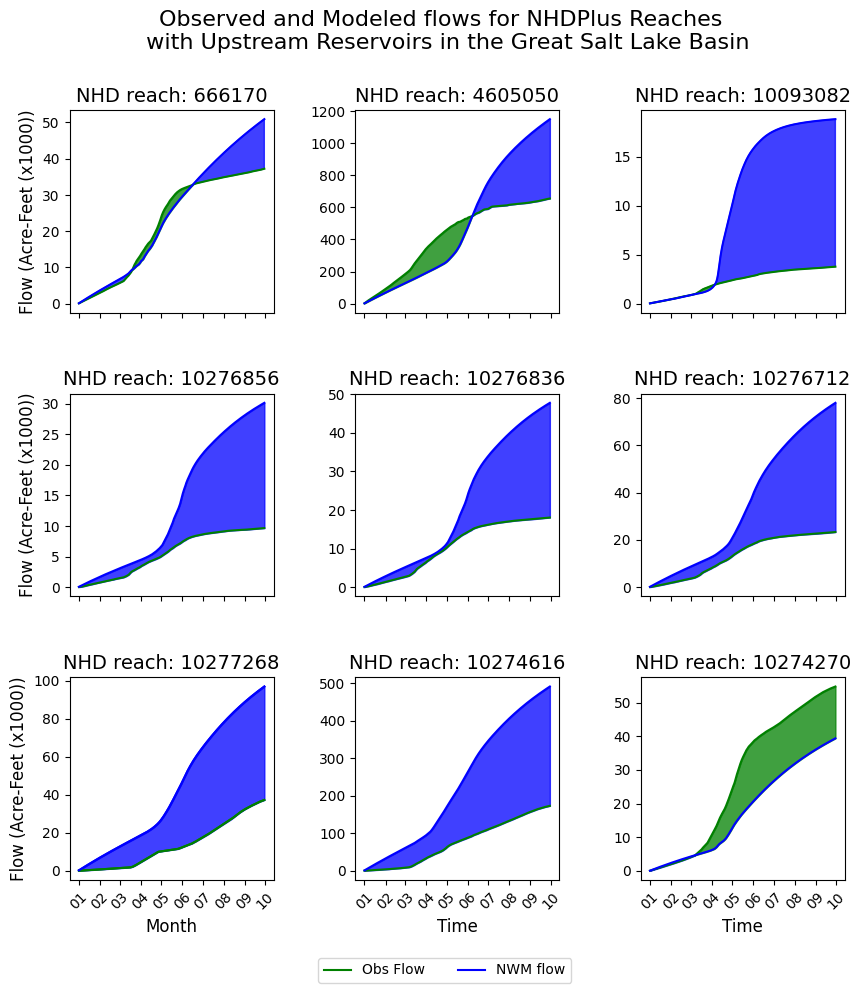

In [34]:
import FigureGenerator

model = 'MLP'
plotname = 'MLP_TS_plot'
freq = 'D'
supply = True
fill_between = True
title = 'Observed and Modeled flows for NHDPlus Reaches \n with Upstream Reservoirs in the Great Salt Lake Basin'
FigureGenerator.TS_plot(SitesDict, model, plotname, title, freq, supply, fill_between)

In [ ]:
plotname = 'MLP_ParityPlot'
FigureGenerator.Parity_plot(SitesDict, model, plotname)

In [ ]:
import AWS_transfer
model = 'MLP'
AWS_transfer.Predictions2AWS(model)